# UCI regression with outliers

In [1]:
import jax
import pickle
import datagen
import pandas as pd
import numpy as np
import jax.numpy as jnp
import seaborn as sns
import flax.linen as nn
import matplotlib.pyplot as plt

from tqdm import tqdm
from time import time
from functools import partial
from rebayes_mini import callbacks
from bayes_opt import BayesianOptimization
from rebayes_mini.methods import student_t_filter as stf
from rebayes_mini.methods import gauss_filter as kf
from rebayes_mini.methods import robust_filter as rkf
from rebayes_mini.methods import generalised_bayes_filter as gbf

In [2]:
%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = "retina"

plt.rcParams["font.size"] = 18
cmap = {
    "KF-IW": "crimson",
    "WLF-IMQ": "dodgerblue",
    "KF": "lightseagreen",
    "WLF-MD": "gold",
    "KF-B": "darkorange",
}

## Load dataset

In [3]:
uci = datagen.UCIDatasets("./data")
for dataset_name in sorted(uci.datasets, key=lambda x: -len(x)):
    dataset = uci.load_dataset(dataset_name)
    print(dataset_name, dataset.shape)

protein-tertiary-structure (45731, 10)
naval-propulsion-plant (11935, 18)
wine-quality-red (1600, 12)
bostonHousing (507, 14)
power-plant (9569, 5)
concrete (1031, 9)
energy (769, 9)
kin8nm (8193, 9)
yacht (309, 7)


In [11]:
dataset_name = "yacht"
noise_type = "target" # or "covariate"

X_collection= []
y_collection = []
ix_clean_collection = []

n_runs = 100
v_error = 50
seed_init = 314
p_error = 0.30
for i in range(n_runs):
    if noise_type == "target":
        data = uci.sample_one_sided_noisy_dataset(dataset_name, p_error=p_error, seed=seed_init + i, v_error=v_error)
        ix_clean = ~data["err_where"].astype(bool)
    elif noise_type == "covariate":
        data = uci.sample_noisy_covariates(dataset_name, p_error=p_error, seed=seed_init + i, v_error=v_error)
        ix_clean = ~data["err_where"].any(axis=1).astype(bool)
    else:
        raise KeyError(f"Noise {noise_type} not available")
        
    X = data["X"]
    y = data["y"]
    
    
    X_collection.append(X)
    y_collection.append(y)
    ix_clean_collection.append(ix_clean)

In [68]:
n_samples = y.shape[0]
X_collection = jnp.array(X_collection)
y_collection = jnp.array(y_collection)
mask_clean = np.array(ix_clean_collection).T
X_collection.shape

(100, 279, 6)

## Setup

In [13]:
class MLP(nn.Module):
    @nn.compact
    def __call__(self, x):
        x = nn.Dense(20)(x)
        x = nn.relu(x)
        x = nn.Dense(1)(x)
        return x

In [14]:
def callback_fn(bel, bel_pred, y, x, applyfn):
    yhat = applyfn(bel_pred.mean, x[None])
    return yhat

In [15]:
y, X = y_collection[0], X_collection[0]
ix_clean = ix_clean_collection[0]

In [16]:
Q = 0.0
observation_covariance = 1.0

In [17]:
key = jax.random.PRNGKey(314)
model = MLP()
def latent_fn(x): return x
measurement_fn = model.apply
params_init = model.init(key, X[:1])

# Run experiments

In [63]:
time_methods = {}
hist_methods = {}
configs = {}

In [ ]:
observation_covariance = jnp.eye(1) * 1.0

## Kalman Filter

In [86]:
def filter_kf(log_lr, measurements, covariates):
    lr = jnp.exp(log_lr)
    nsteps = len(measurements)
    agent = rkf.ExtendedKalmanFilterIMQ(
        latent_fn, measurement_fn,
        dynamics_covariance=Q,
        observation_covariance=observation_covariance,
        soft_threshold=1e8,
    )
    
    init_bel = agent.init_bel(params_init, cov=lr)
    callback = partial(callback_fn, applyfn=agent.vobs_fn)
    bel, yhat_pp = agent.scan(init_bel, measurements, covariates, callback_fn=callback)
    
    # out = (agent, bel)
    return yhat_pp.squeeze()


@jax.jit
def opt_step(log_lr):
    yhat_pp = filter_kf(log_lr, y, X)
    err = jnp.power(yhat_pp - y, 2)
    err = jnp.median(err)
    err = jax.lax.cond(jnp.isnan(err), lambda: 1e6, lambda: err)
    return -err

In [87]:
%%time
bo = BayesianOptimization(
    opt_step,
    pbounds={
        "log_lr": (-5, 0),
    },
    verbose=2,
    random_state=314,
    allow_duplicate_points=True
)

bo.maximize(init_points=5, n_iter=10)

|   iter    |  target   |  log_lr   |
-------------------------------------
| 1         | -217.5    | -0.4156   |
| 2         | -30.11    | -2.057    |
| 3         | -17.41    | -3.675    |
| 4         | -150.1    | -1.084    |
| 5         | -112.7    | -0.41     |
| 6         | -17.41    | -3.672    |
| 7         | -75.08    | -2.048    |
| 8         | -70.45    | -2.066    |
| 9         | -15.35    | -3.685    |
| 10        | -22.14    | -3.695    |
| 11        | -17.38    | -3.658    |
| 12        | -15.35    | -3.684    |
| 13        | -17.41    | -3.672    |
| 14        | -192.8    | -0.3925   |
| 15        | -20.08    | -3.642    |
CPU times: user 18.8 s, sys: 22 s, total: 40.7 s
Wall time: 961 ms


In [88]:
method = "KF"
log_lr = bo.max["params"]["log_lr"]
configs[method] = bo.max["params"]

hist_bel = []
times = []

for yc, Xc in tqdm(zip(y_collection, X_collection), total=n_samples): 
    tinit = time()
    run = jax.jit(filter_kf)(log_lr, y, X)
    tend = time()
    
    hist_bel.append(run)
    times.append(tend - tinit)

hist_bel = np.stack(hist_bel)

hist_methods[method] = hist_bel
time_methods[method] = times

 36%|████████████████████████████████████████████▊                                                                                | 100/279 [00:00<00:01, 175.51it/s]


In [89]:
jnp.median(jnp.power(hist_methods["KF"] - y_collection, 2), 1)

Array([15.348529 , 11.177577 , 12.433254 , 12.997452 , 17.899286 ,
       16.554876 , 11.039675 , 14.031954 , 17.623228 , 18.863537 ,
       14.759299 , 17.16681  , 15.172733 , 14.455761 , 12.637127 ,
       19.20538  , 13.484193 , 17.438782 , 15.5674   , 13.998335 ,
       12.865756 , 12.88591  , 19.253862 , 21.086386 , 17.026361 ,
       14.295187 , 14.366652 , 14.913843 , 12.702581 , 21.757416 ,
       18.746393 , 14.921144 ,  9.959514 , 19.077309 , 18.78452  ,
       13.860577 , 17.327274 , 15.972984 , 13.56178  , 12.580549 ,
       14.892221 , 14.998404 , 12.805067 , 12.543537 , 17.706808 ,
       15.0138035, 12.537257 , 13.254235 , 19.138464 , 11.526821 ,
       18.986135 , 14.980341 , 16.558716 , 11.201668 , 18.628456 ,
       16.909552 ,  9.8960285, 19.153507 , 10.600902 , 13.58315  ,
       17.086695 , 17.481432 , 14.017148 , 12.049448 , 17.08999  ,
        9.987476 , 13.093484 , 13.2756405, 20.998201 , 14.062285 ,
       15.030573 , 10.999929 , 12.531969 , 18.848583 , 23.6038

## KF-IW

In [97]:
@jax.jit
def filter_kfiw(log_lr, noise_scaling, n_inner, measurements, covariates):
    lr = jnp.exp(log_lr)
    n_inner = n_inner.astype(int)
    
    agent = rkf.ExtendedKalmanFilterInverseWishart(
        latent_fn, measurement_fn,
        dynamics_covariance=Q,
        prior_observation_covariance=observation_covariance,
        n_inner=n_inner,
        noise_scaling=noise_scaling
    )
    
    init_bel = agent.init_bel(params_init, cov=lr)
    callback = partial(callback_fn, applyfn=agent.vobs_fn)
    bel, yhat_pp = agent.scan(init_bel, measurements, covariates, callback_fn=callback)
    
    return yhat_pp.squeeze()


@jax.jit
def opt_step(log_lr, noise_scaling, n_inner):
    yhat_pp = filter_kfiw(log_lr, noise_scaling, n_inner, y, X)
    err = jnp.power(yhat_pp - y, 2)
    err = jnp.median(err)
    err = jax.lax.cond(jnp.isnan(err), lambda: 1e6, lambda: err)
    return -err

In [98]:
bo = BayesianOptimization(
    opt_step,
    pbounds={
        "log_lr": (-5, 0),
        "noise_scaling": (1e-6, 20),
        "n_inner":  (1, 10),
    },
    random_state=314,
    verbose=1
)
bo.maximize(init_points=20, n_iter=30)

|   iter    |  target   |  log_lr   |  n_inner  | noise_... |
-------------------------------------------------------------
| 8         | -0.02704  | -1.564    | 4.95      | 6.419     |
| 10        | -0.02264  | -0.826    | 1.952     | 1.208     |
| 25        | -0.0226   | -0.1715   | 1.0       | 3.535     |
| 27        | -0.008469 | -3.189    | 4.799     | 1e-06     |
| 32        | -0.006941 | -2.164    | 10.0      | 1e-06     |
| 34        | -0.005998 | -2.236    | 8.389     | 1e-06     |


In [99]:
method = "KF-IW"
configs[method] = bo.max["params"]

hist_bel = []
times = []

for yc, Xc in tqdm(zip(y_collection, X_collection), total=n_samples): 
    tinit = time()
    run = filter_kfiw(**bo.max["params"], measurements=y, covariates=X)
    tend = time()
    
    hist_bel.append(run)
    times.append(tend - tinit)

hist_bel = np.stack(hist_bel)

hist_methods[method] = hist_bel
time_methods[method] = times

 36%|█████████████████████████████████████████████▏                                                                                | 100/279 [00:02<00:04, 38.27it/s]


## WLF-IMQ

In [ ]:
observation_covariance = jnp.eye(1) * 1.0

In [122]:
@jax.jit
def filter_wlfimq(log_lr, soft_threshold, measurements, covariates):
    lr = jnp.exp(log_lr)
    nsteps = len(measurements)
    agent = rkf.ExtendedKalmanFilterIMQ(
        latent_fn, measurement_fn,
        dynamics_covariance=Q,
        observation_covariance=observation_covariance,
        soft_threshold=soft_threshold,
    )
    
    init_bel = agent.init_bel(params_init, cov=lr)
    callback = partial(callback_fn, applyfn=agent.vobs_fn)
    bel, yhat_pp = agent.scan(init_bel, measurements, covariates, callback_fn=callback)
    
    # out = (agent, bel)
    return yhat_pp.squeeze()


@jax.jit
def opt_step(log_lr, soft_threshold):
    yhat_pp = filter_wlfimq(log_lr, soft_threshold, y, X)
    err = jnp.power(yhat_pp - y, 2)
    err = jnp.median(err)
    err = jax.lax.cond(jnp.isnan(err), lambda: 1e6, lambda: err)
    return -err

In [123]:
%%time
bo = BayesianOptimization(
    opt_step,
    pbounds={
        "log_lr": (-5, 0),
        "soft_threshold": (1e-6, 20)
    },
    verbose=2,
    random_state=314,
    allow_duplicate_points=True
)

bo.maximize(init_points=5, n_iter=10)

|   iter    |  target   |  log_lr   | soft_t... |
-------------------------------------------------
| 1         | -0.7689   | -0.4156   | 11.77     |
| 2         | -0.1681   | -3.675    | 15.66     |
| 3         | -2.302    | -0.41     | 16.55     |
| 4         | -0.03407  | -1.36     | 5.21      |
| 5         | -0.03718  | -0.4412   | 5.215     |
| 6         | -0.02439  | -0.9045   | 2.404     |
| 7         | -0.08239  | -5.0      | 12.83     |
| 8         | -0.07057  | -5.0      | 1.84      |
| 9         | -0.06774  | -5.0      | 7.668     |
| 10        | -0.1498   | -5.0      | 20.0      |
| 11        | -0.1916   | -2.501    | 0.008018  |
| 12        | -0.06837  | -5.0      | 4.745     |
| 13        | -0.1081   | -4.994    | 16.98     |
| 14        | -0.07399  | -1.641    | 8.252     |
| 15        | -0.1958   | 0.0       | 1e-06     |
CPU times: user 59.4 s, sys: 1min 9s, total: 2min 8s
Wall time: 2.2 s


In [124]:
method = "WLF-IMQ"
log_lr = bo.max["params"]["log_lr"]
configs[method] = bo.max["params"]

hist_bel = []
times = []

for yc, Xc in tqdm(zip(y_collection, X_collection), total=n_samples): 
    tinit = time()
    run = filter_wlfimq(**bo.max["params"], measurements=y, covariates=X)
    tend = time()
    
    hist_bel.append(run)
    times.append(tend - tinit)

hist_bel = np.stack(hist_bel)

hist_methods[method] = hist_bel
time_methods[method] = times

 36%|████████████████████████████████████████████▊                                                                                | 100/279 [00:00<00:01, 175.63it/s]


## Summary

In [125]:
pd.DataFrame(jax.tree_map(
    lambda x: np.median(np.power(x - y_collection, 2), 1),
    hist_methods
)).describe()

,KF,KF-IW,WLF-IMQ
count,100.000000,100.000000,100.000000
mean,15.475965,0.059202,0.109128
std,3.031744,0.022220,0.021690
min,9.281091,0.005998,0.024394
25%,13.129737,0.046763,0.095283
50%,15.022188,0.053991,0.106785
75%,17.644123,0.067338,0.117881
max,23.603823,0.180451,0.198198


In [126]:
pd.DataFrame(time_methods).describe()

,KF,KF-IW,WLF-IMQ
count,100.000000,100.000000,100.000000
mean,0.005571,0.025979,0.005581
std,0.028993,0.037802,0.028748
min,0.000201,0.000079,0.000054
25%,0.000251,0.000173,0.000101
50%,0.003839,0.032764,0.003918
75%,0.003960,0.032898,0.004021
max,0.292084,0.369029,0.289616


----
# Old methods

## WLF-IMQ

In [46]:
@jax.jit
def filter_wlfimq(soft_threshold, measurements, state):
    nsteps = len(measurements)
    agent = rkf.ExtendedKalmanFilterIMQ(
        latent_fn, measurement_fn,
        dynamics_covariance=dgen.dynamics_covariance,
        observation_covariance=dgen.observation_covariance,
        soft_threshold=soft_threshold,
    )
    
    init_bel = agent.init_bel(initial_mean, cov=1.0)
    filterfn = partial(agent.scan, callback_fn=callbacks.get_updated_mean)
    _, hist = filterfn(init_bel, measurements, jnp.ones(n_steps))

    err = jnp.sqrt(jnp.power(hist - state, 2).sum(axis=0))
    return err, hist


@jax.jit
def bo_filter_wlfimq(soft_threshold):
    err, _ = filter_wlfimq(soft_threshold, yv[0], statev[0])
    return -err.max()

In [47]:
bo = BayesianOptimization(
    bo_filter_wlfimq,
    pbounds={
        "soft_threshold": (1e-6, 20)
    },
    random_state=314,
    verbose=1,
    allow_duplicate_points=True
)
bo.maximize(init_points=20, n_iter=30)

|   iter    |  target   | soft_t... |
-------------------------------------
| 2         | -129.8    | 11.77     |
| 3         | -128.3    | 5.301     |
| 8         | -128.2    | 5.21      |
| 22        | -125.1    | 3.628     |


In [48]:
method = "WLF-IMQ"
soft_threshold = bo.max["params"]["soft_threshold"]
configs[method] = bo.max["params"]

hist_bel = []
times = []

for y, state in tqdm(zip(yv, statev), total=n_samples): 
    tinit = time()
    _, run = filter_wlfimq(soft_threshold, y, state)
    tend = time()
    
    hist_bel.append(run)
    times.append(tend - tinit)

hist_bel = np.stack(hist_bel)

hist_methods[method] = hist_bel
time_methods[method] = times

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [00:09<00:00, 53.66it/s]


## WLF-MD

In [49]:
@jax.jit
def filter_wlfmd(threshold, measurements, state):
    agent = rkf.ExtendedKalmanFilterMD(
        latent_fn, measurement_fn,
        dynamics_covariance=dgen.dynamics_covariance,
        observation_covariance=dgen.observation_covariance,
        threshold=threshold
    )
    
    init_bel = agent.init_bel(initial_mean, cov=1.0)
    
    _, hist = agent.scan(
        init_bel, measurements, jnp.ones(n_steps), callback_fn=callbacks.get_updated_mean
    )

    err = jnp.sqrt(jnp.power(hist - state, 2).sum(axis=0))
    return err, hist


@jax.jit
def bo_filter_wlfmd(threshold):
    err, _ = filter_wlfmd(threshold, yv[0], statev[0])
    return -err.max()

In [50]:
bo = BayesianOptimization(
    bo_filter_wlfmd,
    pbounds={
        "threshold": (1e-6, 20)
    },
    random_state=314,
    verbose=1
)
bo.maximize(init_points=20, n_iter=30)

|   iter    |  target   | threshold |
-------------------------------------
| 3         | -130.3    | 5.301     |
| 29        | -130.1    | 3.112     |


In [51]:
method = "WLF-MD"
threshold = bo.max["params"]["threshold"]
configs[method] = bo.max["params"]

hist_bel = []
times = []

for y, state in tqdm(zip(yv, statev), total=n_samples): 
    tinit = time()
    _, run = filter_wlfmd(threshold, y, state)
    tend = time()
    
    hist_bel.append(run)
    times.append(tend - tinit)

hist_bel = np.stack(hist_bel)

hist_methods[method] = hist_bel
time_methods[method] = times

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [00:09<00:00, 50.17it/s]


## KF-B

In [52]:
@jax.jit
def filter_kfb(alpha, beta, n_inner, measurements, state):
    """
    Outlier ekf
    """
    n_inner = n_inner.astype(int)
    agent = rkf.ExtendedKalmanFilterBernoulli(
        latent_fn, measurement_fn,
        dynamics_covariance=dgen.dynamics_covariance,
        observation_covariance=dgen.observation_covariance,
        alpha=alpha,
        beta=beta,
        tol_inlier=1e-7,
        n_inner=n_inner,
    )

    init_bel = agent.init_bel(initial_mean, cov=1.0)
    
    _, hist = agent.scan(
        init_bel, measurements, jnp.ones(n_steps), callback_fn=callbacks.get_updated_mean
    )

    err = jnp.sqrt(jnp.power(hist - state, 2).sum(axis=0))
    return err, hist


@jax.jit
def bo_filter_kfb(alpha, beta, n_inner):
    err, _ = filter_kfb(alpha, beta, n_inner, yv[0], statev[0])
    err = -err.max()
    err = jax.lax.cond(jnp.isnan(err), lambda: -1e6, lambda: err)
    return err

In [53]:
bo = BayesianOptimization(
    bo_filter_kfb,
    pbounds={
        "alpha": (0.0, 5.0),
        "beta": (0.0, 5.0),
        "n_inner": (1, 10),
    },
    random_state=314,
    verbose=1
)
bo.maximize(init_points=20, n_iter=30)

|   iter    |  target   |   alpha   |   beta    |  n_inner  |
-------------------------------------------------------------
| 16        | -467.5    | 4.892     | 1.549     | 3.341     |
| 25        | -347.2    | 5.0       | 0.0       | 3.867     |
| 40        | -147.7    | 1.414     | 0.04261   | 2.402     |


In [54]:
method = "KF-B"
alpha = bo.max["params"]["alpha"]
beta = bo.max["params"]["beta"]
n_inner = bo.max["params"]["n_inner"]
configs[method] = bo.max["params"]

hist_bel = []
times = []

for y, state in tqdm(zip(yv, statev), total=n_samples): 
    tinit = time()
    _, run = filter_kfb(alpha, beta, n_inner, y, state)
    tend = time()
    
    hist_bel.append(run)
    times.append(tend - tinit)

hist_bel = np.stack(hist_bel)

hist_methods[method] = hist_bel
time_methods[method] = times

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [00:34<00:00, 14.41it/s]


## Store data

In [55]:
data = {
    "datasets": jax.tree_map(np.array, datasets),
    "time": {k: np.array(v) for k, v in time_methods.items()},
    "posterior-states": hist_methods,
    "config": configs,
    "name": name_dgen
}

In [56]:
with open(f"./results/2d-ssm-outlier-{name_dgen}.pkl", "wb") as f:
    pickle.dump(data, f)

In [57]:
err_methods = jax.tree_map(lambda x: x - statev, hist_methods)

## Plot comparison

In [58]:
diff_df = jax.tree_map(lambda x: np.sum(x ** 2, axis=1), err_methods)

diff_df = pd.concat([
    pd.DataFrame(diff_df[k]).reset_index().melt("index").assign(method=k)
    for k in diff_df
])
diff_df = diff_df.rename(
    {
        "variable": "state",
        "value": "error",
        "index": "trial"
    },
    axis=1
)

# diff_df["state"] = diff_df["state"].apply(lambda x: rf"$\theta_{x}$")

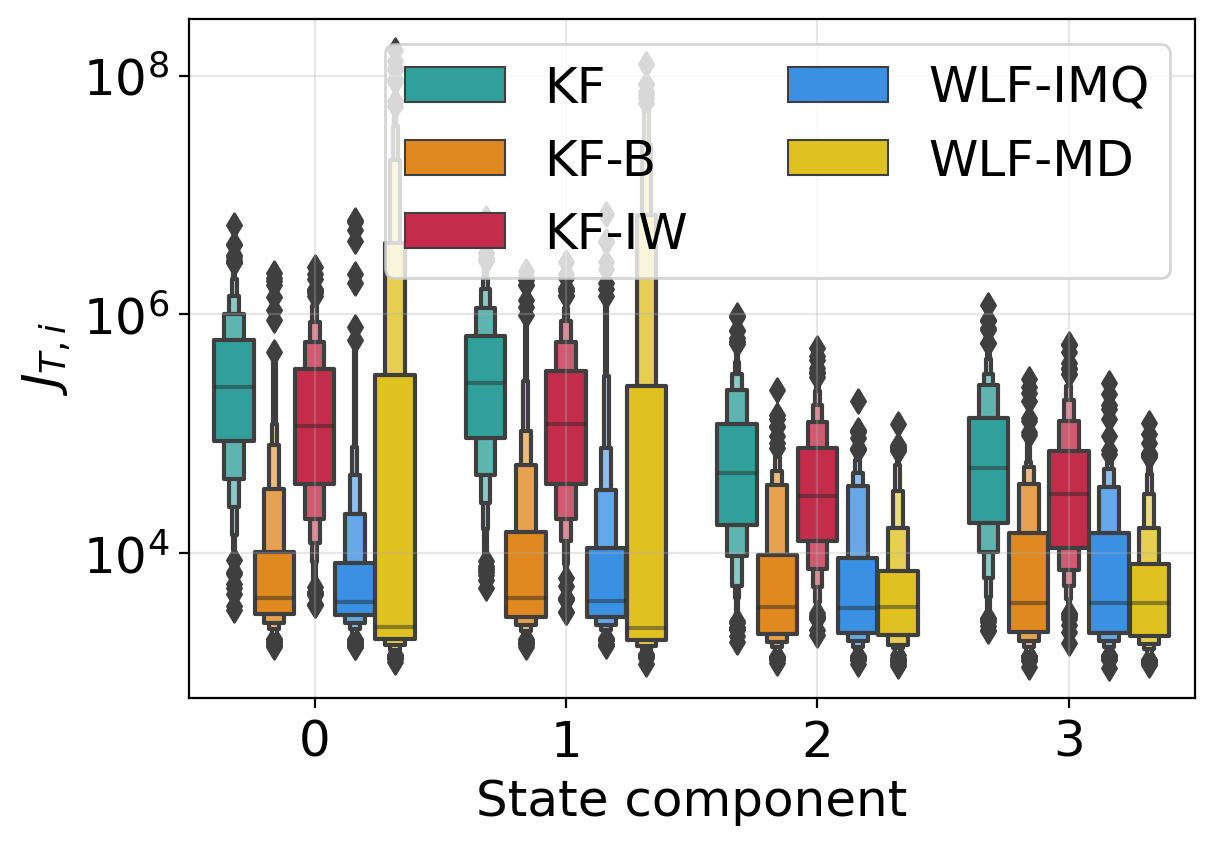

In [59]:
methods = sorted(diff_df.method.unique())
sns.boxenplot(
    y="error",
    x="state",
    hue="method",
    data=diff_df,
    palette=cmap,
    hue_order=methods,
)
plt.legend(ncol=2)
plt.xlabel("State component")
plt.ylabel("$J_{T,i}$")
plt.grid(alpha=0.3)
plt.tight_layout()
plt.yscale("log")

In [60]:
# remove first iteration (used to compile functions)
time_df = pd.DataFrame(time_methods).iloc[1:]

In [61]:
(time_df.mean(axis=0) / time_df["KF"].mean(axis=0) - 1)

KF         0.000000
KF-IW      4.477084
WLF-IMQ    0.000111
WLF-MD     0.068111
KF-B       2.752981
dtype: float64

In [62]:
summary = pd.merge(
    diff_df,
    time_df.reset_index().melt("index").rename({"index": "trial", "variable": "method"}, axis=1),
    on=["method", "trial"],
    how="inner"
)
summary.head()

,trial,state,error,method,value
0,1,0,1.231523e+05,KF,0.000273
1,1,1,1.822057e+06,KF,0.000273
2,1,2,2.173264e+04,KF,0.000273
3,1,3,3.875167e+05,KF,0.000273
4,2,0,4.646637e+05,KF,0.000060


In [63]:
(time_df / time_df["KF"].mean()).describe().loc["mean"].round(1).sort_index()

KF         1.0
KF-B       3.8
KF-IW      5.5
WLF-IMQ    1.0
WLF-MD     1.1
Name: mean, dtype: float64

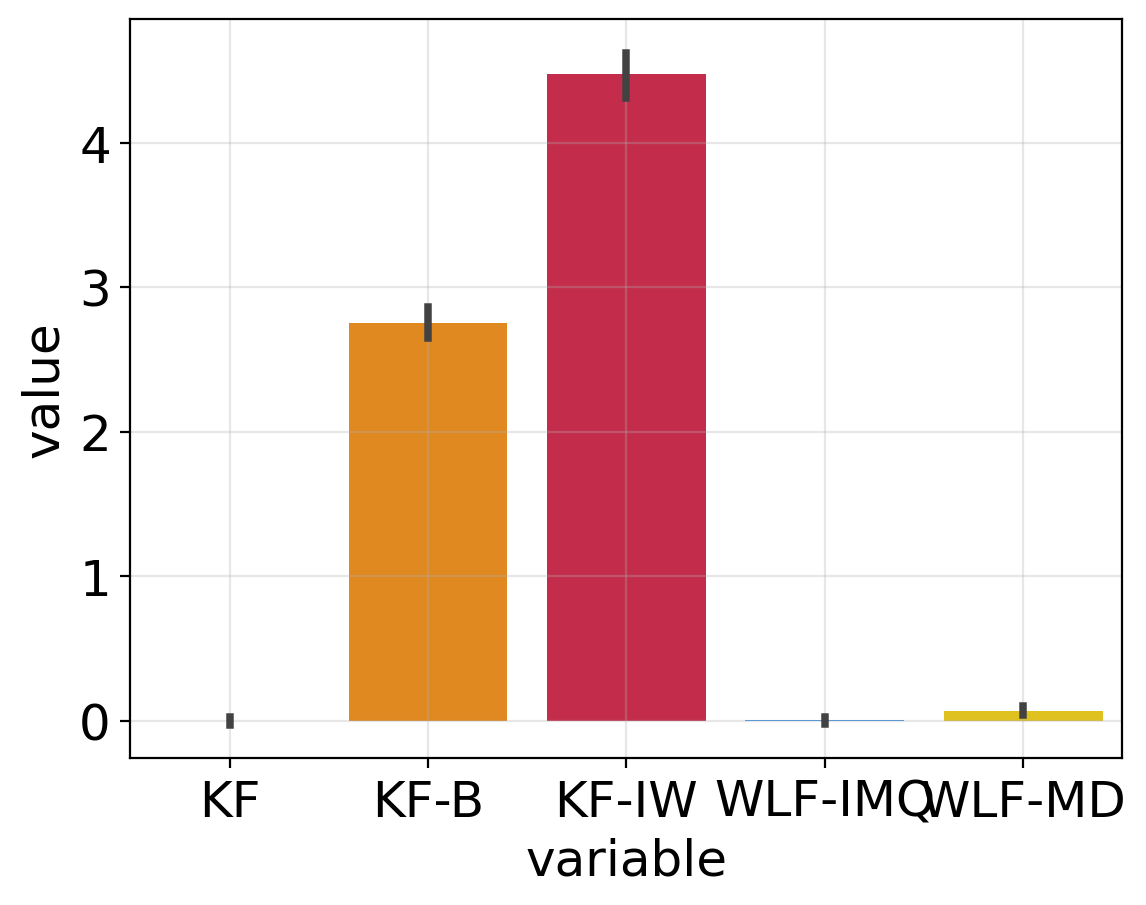

In [64]:
sns.barplot(
    x="variable",
    y="value",
    data=(time_df / time_df["KF"].mean() - 1).melt(),
    order=methods,
    palette=cmap
)
plt.grid(alpha=0.3)

## Single model comparison

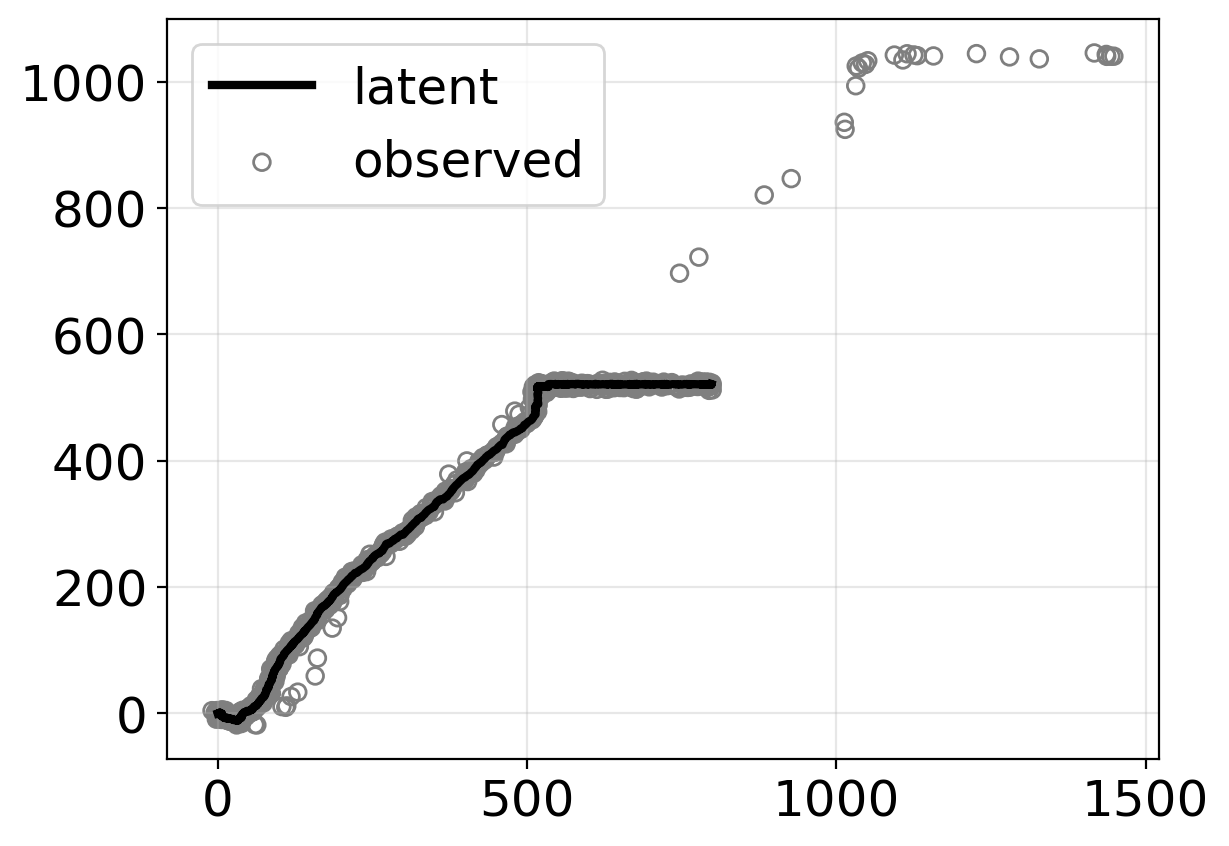

In [65]:
i = 11
# i = 2
latent_i = datasets["latent"][i, :, :2].T
observed_i = yv[i]

plt.plot(*latent_i, c="black", label="latent", linewidth=3)
plt.scatter(*observed_i.T, c="none", edgecolor="tab:gray", label="observed")
plt.legend()
plt.grid(alpha=0.3)

In [66]:
hist_runs = jax.tree_map(lambda x: x[i, :, :2], hist_methods)

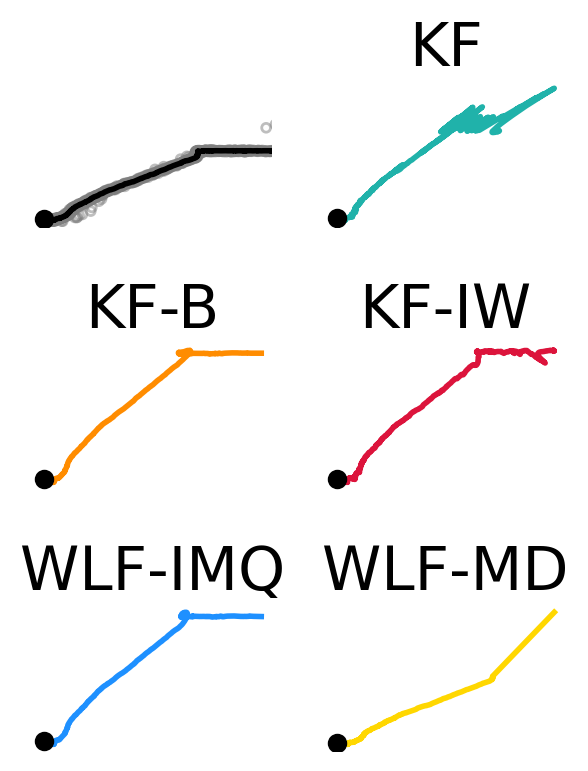

In [67]:
fig, axs = plt.subplots(3, 2, figsize=(6.4 * 0.5, 4.2))

for ax, key in zip(axs.ravel()[1:], hist_runs):
    state_est = hist_runs[key]
    ax.plot(*state_est.T, c=cmap[key], linewidth=2)
    ax.set_title(key)
    ax.axis("off")
    ax.scatter(0,0, c="black", zorder=3)
    
ylim = ax.get_ylim()
xlim = ax.get_xlim()

axs[0, 0].scatter(*observed_i.T, c="none", edgecolor="tab:gray", label="observed", alpha=0.5, s=10)
axs[0, 0].plot(*latent_i, c="black", label="latent", linewidth=2.0)
axs[0, 0].axis("off")
axs[0, 0].scatter(0, 0, c="black", zorder=3)
axs[0, 0].set_ylim(*ylim)
axs[0, 0].set_xlim(*xlim)


plt.tight_layout()
# plt.savefig(f"./figures/2d-ssm-comparison-single-run-{name_dgen}.png", dpi=300)